In [ ]:
import zipfile, os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ZIPPATH = "/content/drive/MyDrive/data_CV/MoNuSAC_patches_0.25um_512.zip"
EXTRACTDIR = "/content"  # plus rapide

with zipfile.ZipFile(ZIPPATH, 'r') as z:
    z.extractall(EXTRACTDIR)

DATA_ROOT = "/content/MoNuSAC_patches_0.25um_512"
print("Dossier data :", DATA_ROOT, "->", os.listdir(DATA_ROOT))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dossier data : /content/MoNuSAC_patches_0.25um_512 -> ['train', 'image_metadata.csv', 'val']


## Data Loader creation

In [ ]:
NUM_CLASSES = 6  # 0=background, 1..5=nuclei

class MonuSacPatchesDatasetOneHot(Dataset):
    def __init__(self, root_dir, subset="train", transform_img=None):
        self.root_dir = Path(root_dir)
        self.subset = subset
        self.img_dir = self.root_dir / subset / "images"
        self.mask_dir = self.root_dir / subset / "masks"

        self.img_paths = sorted(list(self.img_dir.glob("*.png")))
        self.transform_img = transform_img

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_dir / img_path.name

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # L, labels 0..5

        if self.transform_img is not None:
            img = self.transform_img(img)
        else:
            img = transforms.ToTensor()(img)

        mask_np = np.array(mask, dtype=np.int64)          # [H,W]
        # One-hot -> [H,W,C]
        mask_onehot = np.eye(NUM_CLASSES, dtype=np.float32)[mask_np]
        # [C,H,W]
        mask_onehot = np.transpose(mask_onehot, (2, 0, 1))
        mask_tensor = torch.from_numpy(mask_onehot)       # float 0/1

        return img, mask_tensor


In [ ]:
DATA_ROOT = "/content/MoNuSAC_patches_0.25um_512"

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

train_dataset = MonuSacPatchesDatasetOneHot(DATA_ROOT, "train", transform_img=img_transform)
val_dataset   = MonuSacPatchesDatasetOneHot(DATA_ROOT, "val",   transform_img=img_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False, num_workers=2)


## U-Net blocks

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.down(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear',
                                  align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2,
                                         kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        self.bilinear = bilinear

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1,
                   [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_classes, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNetDeeper(nn.Module):
    """
    5 encoder levels instead of 4.
    For 512x512 inputs, lowest resolution is 16x16.
    """
    def __init__(self, n_channels=3, n_classes=6, bilinear=True):
        super().__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # encoder
        self.inc   = DoubleConv(n_channels, 64)    # 512x512
        self.down1 = Down(64,   128)               # 256x256
        self.down2 = Down(128,  256)               # 128x128
        self.down3 = Down(256,  512)               # 64x64
        self.down4 = Down(512, 1024)               # 32x32
        factor = 2 if bilinear else 1
        self.down5 = Down(1024, 2048 // factor)    # 16x16

        # decoder
        self.up1 = Up(2048, 1024 // factor, bilinear)  # 16->32
        self.up2 = Up(1024, 512 // factor,  bilinear)  # 32->64
        self.up3 = Up(512,  256 // factor,  bilinear)  # 64->128
        self.up4 = Up(256,  128 // factor,  bilinear)  # 128->256
        self.up5 = Up(128,  64,              bilinear) # 256->512

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up1(x6, x5)
        x = self.up2(x,  x4)
        x = self.up3(x,  x3)
        x = self.up4(x,  x2)
        x = self.up5(x,  x1)
        logits = self.outc(x)
        return logits


In [ ]:
class DiceLossMultiClass(nn.Module): # Cross Entropy added
    def __init__(self, smooth=1.0, class_weights=None, alpha=0.5):
        """
        alpha: weight for Dice part (0–1). (1-alpha) for CE.
        class_weights: tensor for nuclei classes (C-1) or None.
        """
        super().__init__()
        self.smooth = smooth
        self.class_weights = class_weights
        self.alpha = alpha
        # CE on all classes incl. background
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets_onehot):
        # Cross Entropy
        target_ids = torch.argmax(targets_onehot, dim=1)    # [B,H,W]
        ce_loss = self.ce(logits, target_ids)

        # Dice (without background)
        probs = torch.softmax(logits, dim=1)   # [B,C,H,W]
        probs = probs[:, 1:, ...]
        targets = targets_onehot[:, 1:, ...]

        B, C, H, W = probs.shape
        probs = probs.reshape(B, C, -1)
        targets = targets.reshape(B, C, -1)

        inter = (probs * targets).sum(dim=2)
        union = probs.sum(dim=2) + targets.sum(dim=2)
        dice = (2 * inter + self.smooth) / (union + self.smooth)  # [B,C]

        if self.class_weights is not None:
            # weights for epithelial, lymphocyte, macrophage, neutrophil, ambiguous
            w = self.class_weights.to(dice.device).view(1, C)
            dice = (dice * w).sum(dim=1) / w.sum(dim=1)
        else:
            dice = dice.mean(dim=1)

        dice_loss = 1 - dice.mean()

        # total
        return self.alpha * dice_loss + (1 - self.alpha) * ce_loss


## Training

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 6

model = UNetDeeper(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)


class_weights = torch.tensor([1.0, 1.2, 1.5, 2.0, 0.8], dtype=torch.float32)

criterion = DiceLossMultiClass(smooth=1.0, class_weights=class_weights, alpha=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=7,
)


In [ ]:
def train_one_epoch_dice(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, masks_onehot in loader:
        imgs  = imgs.to(device)                  # [B,3,H,W]
        masks = masks_onehot.to(device).float()  # [B,C,H,W]

        optimizer.zero_grad()
        logits = model(imgs)                     # [B,C,H,W]
        loss = criterion(logits, masks)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)


@torch.no_grad()
def eval_one_epoch_dice(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    for imgs, masks_onehot in loader:
        imgs  = imgs.to(device)
        masks = masks_onehot.to(device).float()

        logits = model(imgs)
        loss = criterion(logits, masks)

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(loader.dataset)

With early stopping

In [ ]:
best_val_loss = float("inf")
best_model_state = None
patience = 10        # nb epoch without improvement
patience_counter = 0

train_losses = []
val_losses = []

N_EPOCHS = 100  # max, early stopping can stop before

for epoch in range(1, N_EPOCHS + 1):
    train_loss = train_one_epoch_dice(model, train_loader, optimizer, criterion, DEVICE)
    val_loss   = eval_one_epoch_dice(model, val_loader,   criterion, DEVICE)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch:03d} | train dice loss: {train_loss:.4f} | "
          f"val dice loss: {val_loss:.4f}")

    # validation scheduler
    scheduler.step(val_loss)


    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, "best_unet_dice.pth")
        print(f"  -> New best model saved (val loss = {best_val_loss:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  -> No improvement, patience {patience_counter}/{patience}")

    # early stopping
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 001 | train dice loss: 1.1858 | val dice loss: 1.2325
  -> New best model saved (val loss = 1.2325)
Epoch 002 | train dice loss: 1.0878 | val dice loss: 1.1779
  -> New best model saved (val loss = 1.1779)
Epoch 003 | train dice loss: 1.0414 | val dice loss: 1.1147
  -> New best model saved (val loss = 1.1147)
Epoch 004 | train dice loss: 1.0084 | val dice loss: 1.0683
  -> New best model saved (val loss = 1.0683)
Epoch 005 | train dice loss: 0.9844 | val dice loss: 1.0110
  -> New best model saved (val loss = 1.0110)
Epoch 006 | train dice loss: 0.9715 | val dice loss: 0.9862
  -> New best model saved (val loss = 0.9862)
Epoch 007 | train dice loss: 0.9509 | val dice loss: 0.9681
  -> New best model saved (val loss = 0.9681)
Epoch 008 | train dice loss: 0.9456 | val dice loss: 0.9792
  -> No improvement, patience 1/10
Epoch 009 | train dice loss: 0.9328 | val dice loss: 0.9565
  -> New best model saved (val loss = 0.9565)
Epoch 010 | train dice loss: 0.9233 | val dice loss: 0.93

In [ ]:
# Keeping the best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Best model (val loss) reloaded.")

Best model (val loss) reloaded.


## Quality of results visualisation

Loss function:

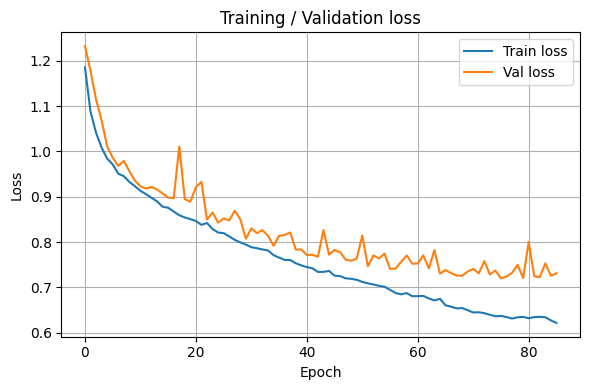

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Confusion matrix:

Allows you to see which classes are confused.

In [ ]:
@torch.no_grad()
def collect_preds_and_labels_onehot(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for imgs, masks_onehot in loader:
        imgs = imgs.to(device)                        # [B,3,H,W]
        masks_onehot = masks_onehot.to(device)        # [B,C,H,W]

        logits = model(imgs)                         # [B,C,H,W]
        preds = torch.argmax(logits, dim=1)          # [B,H,W]
        labels = torch.argmax(masks_onehot, dim=1)   # [B,H,W]

        all_preds.append(preds.cpu().numpy().ravel())
        all_labels.append(labels.cpu().numpy().ravel())

    y_pred = np.concatenate(all_preds, axis=0)
    y_true = np.concatenate(all_labels, axis=0)
    return y_true, y_pred

y_true, y_pred = collect_preds_and_labels_onehot(model, val_loader, DEVICE)
print(y_true.shape, y_pred.shape)

(3407872,) (3407872,)


In [ ]:
class_names = [
    "background",
    "epithelial",
    "lymphocyte",
    "macrophage",
    "neutrophil",
    "ambiguous",
]

cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
print("Confusion matrix shape:", cm.shape)

Confusion matrix shape: (6, 6)


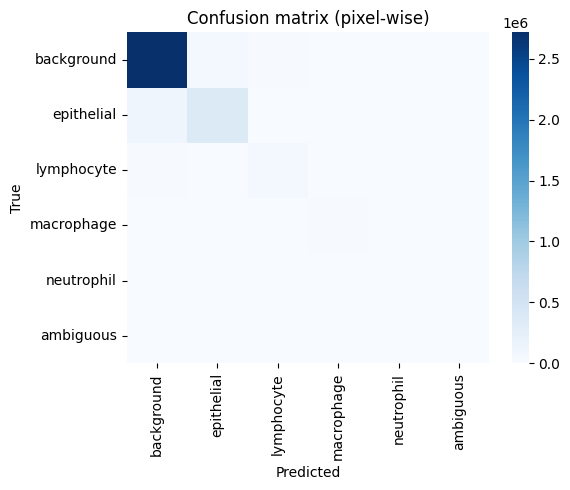

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=False, fmt="d",
    xticklabels=class_names,
    yticklabels=class_names,
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (pixel-wise)")
plt.tight_layout()
plt.show()

IoU:

In [ ]:
@torch.no_grad()
def compute_iou_per_class(model, loader, device, num_classes=NUM_CLASSES):
    model.eval()

    intersection = np.zeros(num_classes, dtype=np.float64)
    union        = np.zeros(num_classes, dtype=np.float64)
    eps = 1e-6

    for imgs, masks_onehot in loader:
        imgs  = imgs.to(device)                  # [B,3,H,W]
        masks_onehot = masks_onehot.to(device)   # [B,C,H,W]

        logits = model(imgs)                     # [B,C,H,W]

        # predicted classes and true classes
        preds  = torch.argmax(logits, dim=1)          # [B,H,W]
        target = torch.argmax(masks_onehot, dim=1)    # [B,H,W]

        for c in range(num_classes):
            pred_c  = (preds  == c)
            target_c = (target == c)

            inter = (pred_c & target_c).sum().item()
            uni   = (pred_c | target_c).sum().item()

            intersection[c] += inter
            union[c]        += uni

    iou = (intersection + eps) / (union + eps)
    return iou

In [ ]:
iou = compute_iou_per_class(model, val_loader, DEVICE, num_classes=NUM_CLASSES)

class_names = [
    "background",
    "epithelial",
    "lymphocyte",
    "macrophage",
    "neutrophil",
    "ambiguous",
]

for c in range(NUM_CLASSES):
    print(f"{class_names[c]:>10}: IoU = {iou[c]:.3f}")

print("Mean IoU (all classes):", iou.mean())
print("Mean IoU (no background):", iou[1:].mean())


background: IoU = 0.923
epithelial: IoU = 0.638
lymphocyte: IoU = 0.560
macrophage: IoU = 0.462
neutrophil: IoU = 0.089
 ambiguous: IoU = 1.000
Mean IoU (all classes): 0.6119907455614931
Mean IoU (no background): 0.5497673511868599
